# Time-series analysis (LSTM, 1D-CNN, 2D-CNN, …)
The aim of this lab (TP) is to a classification system of Human Activity Recognition (HAR).
The data used for classification is provided by the Wireless Sensor Data Mining (WISDM) Lab and can be downloaded directly from the course platform “actitracker_raw.txt”. It consists of 1,098,207 examples of various physical activities (sampled at 20Hz) with 6 attributes: user,activity,timestamp,x-acceleration,y-acceleration,z-acceleration.
The activities include: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing.

This data comes from the [University of Fordham](https://www.cis.fordham.edu/wisdm/dataset.php) and represents the accelerometer data while doing various activities. The aim is to determine which activity is done by analysing the sequence. According to the sources, the number of samples is equal to 1,098,207 divided in 6 classes :

*   Walking: 424,400 (38.6%)
*   Jogging: 342,177 (31.2%)
*   Upstairs: 122,869 (11.2%)
*   Downstairs: 100,427 (9.1%)
*   Sitting: 59,939 (5.5%)
*   Standing: 48,395 (4.4%)


Starting by downloading the data and aploading here:
https://drive.google.com/file/d/1_pNqa6Mq9pPx5qux2FMqWllL3jqzvx_d/view?usp=sharing

We can use pandas to handle the time series. While displaying the values, we observe z-axis is not in the correct format because of the semicolon. we have to convert this data to numerical values. we can notice the presence of a NaN value so it's possible to use linear interpolation replace it.

In [ ]:
import os
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout

from tensorflow.keras.callbacks import TensorBoard

Start by upload the data:

In order to show how the x-acceleration was changing with time (or more accurately - at each timestep) for each one of these activities, you can use this function:

In [ ]:
# Monter votre Drive afin de pouvoir y'acceder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Centrale Lille/G3/actitracker_raw.txt.zip', 'r') as zip_ref:
    zip_ref.extractall("actitracker_raw")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)


def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data


In [ ]:
dataset = readData('actitracker_raw/actitracker_raw.txt')
for activity in np.unique(dataset['activity']):
  subset = dataset[dataset['activity']==activity][:180]
  subset=subset.interpolate()

plotActivity(activity,subset)

In [ ]:
dataset.columns

Index(['user_id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'], dtype='object')

In order to feed the network with such temporal dependencies a sliding time window is used to extract separate data segments. The window width and the step size can be both adjusted and optimised for better accuracy. Each time step is associated with an activity label, so for each segment the most frequently appearing label is chosen. Here, the time segment or window width is chosen to be 90.

In [ ]:
from scipy import stats
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)

# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels =np.append(labels,data['activity'][start:end].mode()[0])
    return segments, labels


The data needs to be separated into features and labels and then further into training and test sets. Labels need to be one-hot encoded before feeding into the classifier. Then,split the data into train/test subset as 80%/20%: train (19522 sequences) and test (4881 sequences).


# 1. Convolutional Neural Network (2D CNN)

If you concatenate the time series columns, you obtain a 2D matrix, on which you can apply a 2D CNN based classification system. Because we want to apply a 2D CNN, it is necessary to add a dimension to our sequences.


You can download the segment files here:
https://drive.google.com/file/d/1u9Nz4-JK-tc0UZn457UX6QjHPOclyJMq/view?usp=sharing

Put it on your Drive and then read it

In [ ]:
# segments, labels = segment_signal(dataset)
# reshapedSeg = segments.reshape(segments.shape[0], segments.shape[1], segments.shape[2],1)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Centrale Lille/G3/HAR-Data-segment.zip', 'r') as zip_ref:
    zip_ref.extractall("segment_data")

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Initialisation du OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False)

# # Appliquer l'encodeur à la colonne 'Label'
# encoded_labels = encoder.fit_transform(labels.reshape(-1, 1))

# # Créer un DataFrame avec les résultats encodés
# encoded_df = pd.DataFrame(encoded_labels, columns=encoder.categories_[0])
# encoded_df.head()

In [ ]:
# Chemin vers le fichier .npy
file_path = '/content/segment_data/'

# Charger le fichier
segments = np.load(f"{file_path}segments.npy")
labels = np.load(f"{file_path}labels.npy")

In [ ]:
print(np.array(segments).shape,np.array(labels).shape)

(24403, 90, 3) (24403, 6)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, shuffle=False)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(19522, 90, 3) (19522, 6) (4881, 90, 3) (4881, 6)


In [ ]:
nan_check = np.isnan(segments).any()
print(f"Are there any NaN values in segments? {nan_check}")

Are there any NaN values in segments? True


In [ ]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

2D CNN need also that the format of labels to be in one hot encoding labels.

Here, you can propose a classification system based on a 2DCNN (you can find an example of a suggested model here:)

In [ ]:
model = models.Sequential(name="sequential")
model.add(layers.Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=(90, 3, 1), name='conv2d'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), name='max_pooling2d'))
model.add(layers.Dropout(0.25, name='dropout'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(128, activation='relu', name='dense'))
model.add(layers.Dense(128, activation='relu', name='dense_1'))
model.add(layers.Dense(6, activation='softmax', name='dense_2'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 89, 2, 128)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 44, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 44, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5632)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         721,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,950 (2.82 MB)

 Trainable params: 738,950 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6782 - loss: 1.0199 - val_accuracy: 0.7525 - val_loss: 0.7426
Epoch 2/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.8281 - loss: 0.4588 - val_accuracy: 0.7242 - val_loss: 0.7284
Epoch 3/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.8610 - loss: 0.3731 - val_accuracy: 0.7646 - val_loss: 0.6860
Epoch 4/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.8778 - loss: 0.3197 - val_accuracy: 0.7285 - val_loss: 0.8605
Epoch 5/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8962 - loss: 0.2808 - val_accuracy: 0.7517 - val_loss: 0.7924
Epoch 6/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9084 - loss: 0.2466 - val_accuracy: 0.7330 - val_loss: 0.8910
Epoch 7/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9165 - loss: 0.2226 - val_accuracy: 0.7427 - val_loss: 0.8381
Epoch 8/50
611/611 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9324 - loss: 0.1913 - 

**Question 1**: Plot performance curves that show the evaluation of the CNN model.

In [ ]:
def plot_perf(history):
  # Tracer les courbes de performance
  # Tracer la courbe de la perte (loss)
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Perte d\'entraînement')
  plt.plot(history.history['val_loss'], label='Perte de validation')
  plt.title('Courbe de la Perte')
  plt.xlabel('Épochs')
  plt.ylabel('Perte')
  plt.legend()

  # Tracer la courbe de la précision (accuracy)
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
  plt.plot(history.history['val_accuracy'], label='Précision de validation')
  plt.title('Courbe de la Précision')
  plt.xlabel('Épochs')
  plt.ylabel('Précision')
  plt.legend()

  plt.tight_layout()
  plt.show()


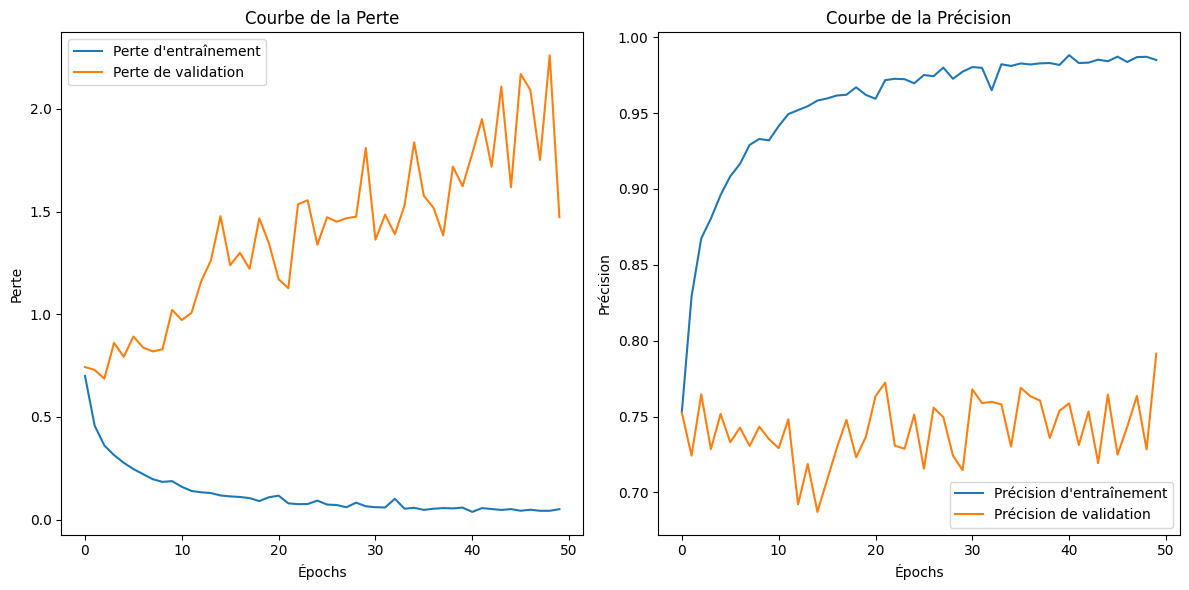

In [ ]:
plot_perf(history)

**2.	Long-Short-Terms-Memory (LSTM)**


Configures an RNN as following:


In [ ]:
# Création du modèle séquentiel
model_lstm = Sequential()

# Ajouter la première couche LSTM avec normalisation par lots
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(90, 3)))  # LSTM avec 128 unités et séquence de sortie
model_lstm.add(BatchNormalization())  # Normalisation par lots

# Ajouter la deuxième couche LSTM avec normalisation par lots
model_lstm.add(LSTM(128))  # LSTM sans sortie séquencée (return_sequences=False)
model_lstm.add(BatchNormalization())  # Normalisation par lots

# Ajouter une couche Dense avec 32 neurones
model_lstm.add(Dense(32, activation='relu'))  # Activation ReLU

# Ajouter une couche Dropout pour régularisation
model_lstm.add(Dropout(0.5))  # Dropout avec un taux de 50%

# Ajouter la couche de sortie Dense avec 6 neurones (probablement pour classification à 6 classes)
model_lstm.add(Dense(6, activation='softmax'))  # Activation Softmax pour classification multiclasse

# Résumé du modèle
model_lstm.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 90, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 90, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,518 (798.90 KB)

 Trainable params: 204,006 (796.90 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 104s 652ms/step - accuracy: 0.7659 - loss: 0.6516 - val_accuracy: 0.6861 - val_loss: 1.0643
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 139s 637ms/step - accuracy: 0.8468 - loss: 0.4150 - val_accuracy: 0.6833 - val_loss: 1.1345
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 99s 650ms/step - accuracy: 0.9021 - loss: 0.2951 - val_accuracy: 0.6822 - val_loss: 1.2987
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 140s 636ms/step - accuracy: 0.9235 - loss: 0.2391 - val_accuracy: 0.7613 - val_loss: 1.0448
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 140s 624ms/step - accuracy: 0.9400 - loss: 0.2043 - val_accuracy: 0.7060 - val_loss: 1.1181
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 96s 629ms/step - accuracy: 0.9560 - loss: 0.1489 - val_accuracy: 0.7423 - val_loss: 1.1623
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 97s 635ms/step - accuracy: 0.9612 - loss: 0.1309 - val_accuracy: 0.7335 - val_loss: 1.1286
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 142s 639ms/step - accuracy: 0.9623 - lo

**Question 2:** Plot performance curves that show the evaluation of the LSTM model and compare it to the previous CNN model.

In [ ]:
plot_perf(history_lstm)

**3. Convolutional Neural Network (1D CNN)**

1D CNN can perform activity recognition task from accelerometer data, such as if the person is standing, walking, jumping etc. This data has 2 dimensions. The first dimension is time-steps and other is the values of the acceleration in 3 axes. To add a Conv1D layer in keras for example:

In [ ]:
# Définir le modèle
model1D = models.Sequential()

# 1ère couche Conv1D
model1D.add(layers.Conv1D(100, 5, activation='relu', input_shape=(90, 3)))

# 2ème couche Conv1D
model1D.add(layers.Conv1D(100, 5, activation='relu'))

# Couche de MaxPooling1D
model1D.add(layers.MaxPooling1D(pool_size=3))

# 3ème couche Conv1D
model1D.add(layers.Conv1D(160, 5, activation='relu'))

# 4ème couche Conv1D
model1D.add(layers.Conv1D(160, 5, activation='relu'))

# Couche de GlobalAveragePooling1D
model1D.add(layers.GlobalAveragePooling1D())

# Couche Dropout
model1D.add(layers.Dropout(0.5))

# Couche Dense finale avec 6 neurones
model1D.add(layers.Dense(6))

# Résumé du modèle
model1D.summary()

In [ ]:
model1D.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_1D = model1D.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

**Question 3:** Test the performance of this model and compare it to the previous models.

In [ ]:
plot_perf(history_1D)

**Question 4:** Extend this model to the Action Recognition from 2D skeleton data.
To do this, you can use this folder contating 3D joints captured from video.
https://drive.google.com/file/d/1PIUkA5ZXb2HFQ9VbLMxQGAjJTkr56YNj/view?usp=sharing
five actions are considered: squat, stand, punch, kick, and wave. The videos are recorded at 10 fps with a frame size of 640 x 480, and then saved to images. From each image, a 2D skeleton is extarcted usin g Open Pose tools.

The generated training data files are located in data folder:
*   skeleton_raw.csv: original data
*   skeleton_filtered.csv: filtered data where incomplete poses are eliminated
 to read the skeleton data, you can use:

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Centrale Lille/G3/data_skeleton.zip', 'r') as zip_ref:
    zip_ref.extractall("skeleton")

In [ ]:
skeleton_data = pd.read_csv('skeleton/data/skeleton_filtered.csv')
skeleton_data.columns

In [ ]:
from scipy.stats import mode

# Paramètres
n = 90  # Taille de la fenêtre
step = 45
features = skeleton_data.columns[:-1]  # Toutes les colonnes sauf celle du label
label_col = 'class'  # Nom de la colonne des labels

# Créer les séquences
sequences = []
labels = []

for i in range(0,len(skeleton_data) - n + 1,step):
    # Extraire la fenêtre de taille `n`
    window = skeleton_data.iloc[i:i+n]

    # Extraire les features et labels
    window_features = window[features].values
    window_labels = window[label_col].values

    # Calculate mode using pandas (supports string values)
    # This line is changed to handle string labels
    label_mode = window[label_col].mode()[0]

    # Ajouter la séquence et le label majoritaire
    sequences.append(window_features)
    labels.append(label_mode)

# Convertir en numpy arrays
X = np.array(sequences)  # Forme (num_samples, n, num_features)
y = np.array(labels)     # Forme (num_samples,)

# Vérification des dimensions
print("Shape of X:", X.shape)  # (num_samples, n, num_features)
print("Shape of y:", y.shape)  # (num_samples,)

In [ ]:
df_encoded = pd.get_dummies(y, dtype=int)
Y = df_encoded.to_numpy()

In [ ]:
X_train, X_test, y_train,  y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

In [ ]:
# Création du modèle séquentiel
model_lstm2 = Sequential()

# Ajouter la première couche LSTM avec normalisation par lots
model_lstm2.add(LSTM(128, return_sequences=True, input_shape=(n, 36)))
model_lstm2.add(BatchNormalization())  # Normalisation par lots

# Ajouter la première couche LSTM avec normalisation par lots
model_lstm2.add(LSTM(128, input_shape=(n, 36)))
model_lstm2.add(BatchNormalization())  # Normalisation par lots

# Ajouter une couche Dense avec 32 neurones
model_lstm2.add(Dense(32, activation='relu'))  # Activation ReLU

# Ajouter une couche Dropout pour régularisation
model_lstm2.add(Dropout(0.5))  # Dropout avec un taux de 50%

# Ajouter la couche de sortie Dense avec 6 neurones (probablement pour classification à 6 classes)
model_lstm2.add(Dense(5, activation='softmax'))  # Activation Softmax pour classification multiclasse

# Résumé du modèle
model_lstm2.summary()

In [ ]:
model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_skeleton = model_lstm2.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test))

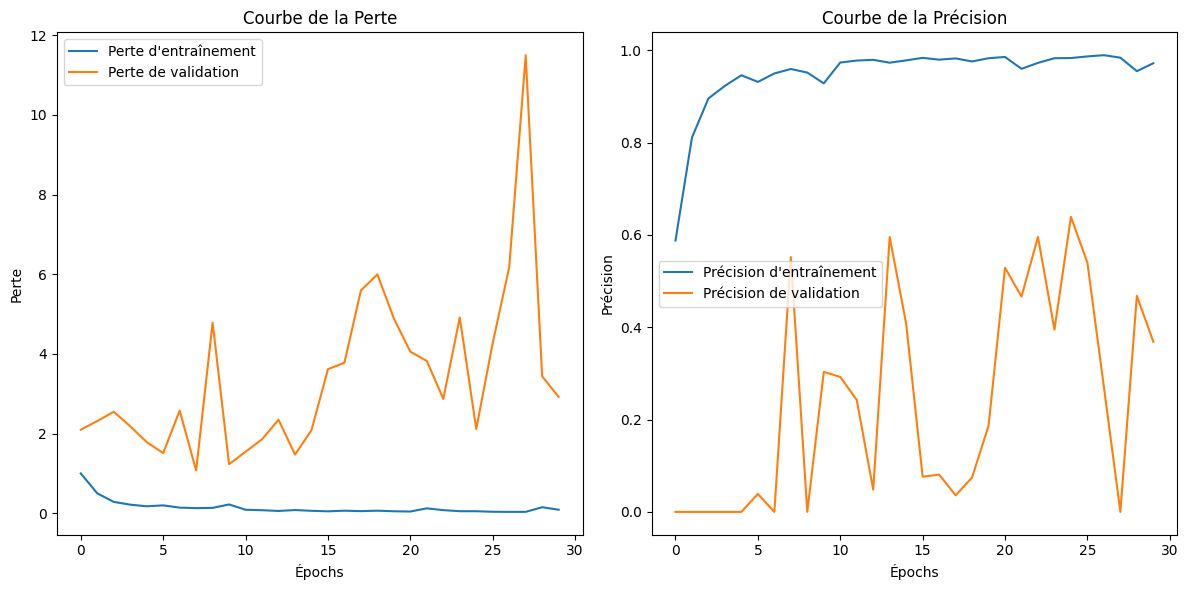

In [ ]:
plot_perf(history_skeleton)